### 2.1 CNN Models - Model Training and Development

A multilabel classifier was developed on the entire dataset of 70,000 images (61,370 as traing and 8,630 as validation). Training set was oversampled on cored plaques and CAAs by duplicating the raw images, which resulted in a total of 155,239 images.

#### Architercture of the Convolutional neural network: 
Convolutional layers contained 6 Conv layers (3x3 kernal size, 1 stride, 1 padding, 0.2 dropout) each was followed by a max pooling layer (2x2 kernal size, 2 stride). 
Fully connected layers had 2 hidden layers (512 and 100 neurons, 0.5 dropout), the output layer had three neurons with Sigmoid activation function.

Rectified Linear Unit (ReLU) was used as non-linear activation function for every layer except the output layer.

#### Training: 
The CNN model was trained in the open-source package PyTorch on four NVIDIA GTX 1080 or Titan X graphics processing units (GPUs) using the Adam optimizer with a multi-label soft margin loss function with weight decay (L2 penalty, 0.008). Training proceeded with mini-batches of 64 images with real-time data augmentation including random flips, rotations, zoom, shear, and color jitter.  


The network obtained 0.842, 0.983 and 0.810 AUC-PRC on validation set for cored plaque, diffuse plaque and cerebral amyloid angiopathy (CAA) respectively.

In [1]:
import time, os

import torch
torch.manual_seed(123456789)
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

import config as cfg

In [2]:

csv_path = {
    'train': 'data/CSVs/tiles_train.csv',
    'dev': 'data/CSVs/tiles_validation.csv',
}

# DATA_DIR = 'data/seg/size_filtered/blobs/'
DATA_DIR = cfg.data_dir + '/tiles/tiles/train/'
NEGATIVE_DIR = cfg.data_dir + '/tiles/tiles/train/'
SAVE_DIR = cfg.data_dir + '/models/'

image_classes = ['cored','diffuse','CAA']

In [3]:
if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

In [4]:
batch_size = 64
num_workers = 16

norm = np.load('utils/normalization.npy', allow_pickle=True).item()

In [5]:
from torch.utils.data import Dataset
from PIL import Image

class MultilabelDataset(Dataset):
    def __init__(self, csv_path, img_path, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_info = pd.read_csv(csv_path)
        self.img_path = img_path
        self.transform = transform
        c=torch.Tensor(self.data_info.loc[:,'cored'])
        d=torch.Tensor(self.data_info.loc[:,'diffuse'])
        a=torch.Tensor(self.data_info.loc[:,'CAA'])
        c=c.view(c.shape[0],1)
        d=d.view(d.shape[0],1)
        a=a.view(a.shape[0],1)
        self.raw_labels = torch.cat([c,d,a], dim=1)
        self.labels = (torch.cat([c,d,a], dim=1)>0.99).type(torch.FloatTensor)

    def __getitem__(self, index):
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.labels[index]
        raw_label = self.raw_labels[index]
        # Get image name from the pandas df
        single_image_name = str(self.data_info.loc[index,'imagename'])
        # Open image
        try:
            img_as_img = Image.open(self.img_path + single_image_name)
        except:
            img_as_img = Image.open(NEGATIVE_DIR + single_image_name)
        # Transform image to tensor
        if self.transform is not None:
            img_as_img = self.transform(img_as_img)
        # Return image and the label
        return (img_as_img, single_image_label, raw_label, single_image_name)

    def __len__(self):
        return len(self.data_info.index)

In [6]:
def imshow(inp, norm, title=None):
    """Imshow for Tensor."""
    try:
        inp = inp.numpy().transpose((1, 2, 0))
    except:
        inp = inp.transpose((1, 2, 0))
    mean = norm['mean']
    std = norm['std']
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.subplots()
    ax.imshow(inp)
    
    if title is not None:
        ax.set_title(title)
    plt.pause(0.001)

In [7]:
def plot_loss(model):
    fig = plt.figure()
    fig.subplots_adjust(left=2, right = 3, wspace=0.3, bottom = 2, top = 3)
    ax = plt.axes()

    ax.plot(model.train_loss_curve, label='train')
    ax.plot(model.dev_loss_curve, label='dev')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend()

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, gpu_id=None):
    since = time.time()

    best_loss = 10000.0
    best_model = copy.deepcopy(model)

    for epoch in range(num_epochs):
        epoch_time = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  
            else:
                model.train(False)  

            running_loss = 0.0
            running_corrects = torch.zeros(len(image_classes))

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels, raw_labels, names = data
                # wrap them in Variable
                if use_gpu:
                    if phase == 'train':
                        inputs = Variable(inputs.cuda(), requires_grad=True)
                    else:
                        inputs = Variable(inputs.cuda(), volatile=True)
                    labels = Variable(labels.cuda(), volatile=True)
                else:
                    if phase == 'train':
                        inputs =  Variable(inputs, requires_grad=True)
                    else:
                        inputs =  Variable(inputs, volatile=True)
                    labels = Variable(labels, volatile=True)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                outputs = model(inputs)
                if use_gpu:
                    predictions = (F.sigmoid(outputs)>0.5).type(torch.cuda.FloatTensor)
                else:
                    predictions = (F.sigmoid(outputs)>0.5).type(torch.FloatTensor)

                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(predictions==labels, 0).data.type(torch.FloatTensor)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                model.module.train_loss_curve.append(epoch_loss)
            else:
                model.module.dev_loss_curve.append(epoch_loss)

            if phase == 'dev' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model = copy.deepcopy(model)
                print('best loss: ', epoch_loss)

            print('{} Loss: {:.4f}\n Cored: {:.4f} Diffuse: {:.4f} CAA: {:.4f}'.format(
                phase, epoch_loss, epoch_acc[0], epoch_acc[1], epoch_acc[2]))

        epoch_end = time.time() - epoch_time
        print('train, Epoch time {:.0f}m {:.0f}s'.format(
                epoch_end // 60, epoch_end % 60))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return best_model

In [9]:
def dev_model(model, criterion, phase='dev'):
    phase = phase
    since = time.time()
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)
              for x in [phase]}

    model.train(False) 

    running_loss = 0.0
    running_corrects = torch.zeros(len(image_classes))
    running_preds = torch.Tensor(0)          # confidence score
    running_predictions = torch.Tensor(0)    # classification prediction
    running_labels = torch.Tensor(0)
    running_raw_labels = torch.Tensor(0)

    # Iterate over data.
    for data in dataloaders[phase]:
        # get the inputs
        inputs, labels, raw_labels, names = data
        running_labels = torch.cat([running_labels, labels])
        running_raw_labels = torch.cat([running_raw_labels, raw_labels])

        # wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # forward
        outputs = model(inputs)
        preds = F.sigmoid(outputs) #posibility for each class
        if use_gpu:
            predictions = (preds>0.5).type(torch.cuda.FloatTensor)
        else:
            predictions = (preds>0.5).type(torch.FloatTensor)
        
        loss = criterion(outputs, labels)

        preds = preds.data.cpu()
        predictions = predictions.data.cpu()
        labels = labels.data.cpu()

        # statistics
        running_loss += loss.data[0]
        running_corrects += torch.sum(predictions==labels, 0).type(torch.FloatTensor)
        running_preds = torch.cat([running_preds, preds])
        running_predictions = torch.cat([running_predictions, predictions])


    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects / dataset_sizes[phase]

    print('{} Loss: {:.4f}\n Cored: {:.4f} Diffuse: {:.4f} CAA: {:.4f}'.format(
                phase, epoch_loss, epoch_acc[0], epoch_acc[1], epoch_acc[2]))

    print()

    time_elapsed = time.time() - since
    print('Prediction complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return epoch_acc, running_preds, running_predictions, running_labels

In [10]:
class Net(nn.Module):

    def __init__(self, fc_nodes=512, num_classes=3, dropout=0.5):
        super(Net, self).__init__()
        
        self.drop = 0.2
     
        self.features = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(64, 64, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(64, 128, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(128, 256, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(256, 256, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(256, 512, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),)
        
        self.classifier = nn.Sequential(nn.Linear(512 * 4 * 4, fc_nodes),
                                        nn.ReLU(True),
                                        nn.Dropout(p=dropout),
                                        nn.Linear(fc_nodes, 100),
                                        nn.ReLU(True),
                                        nn.Dropout(p=dropout),
                                        nn.Linear(100, num_classes))
        
        self.train_loss_curve = []
        self.dev_loss_curve = []

    def forward(self, x):
 
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ColorJitter(brightness=0.1, contrast=0.2,saturation=0.2, hue=0.02),
        transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.9,1.1), shear=10),
        transforms.ToTensor(),
        transforms.Normalize(norm['mean'], norm['std'])
    ]),
    'dev': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(norm['mean'], norm['std'])
    ]),
}

image_datasets = {x: MultilabelDataset(csv_path[x], DATA_DIR, data_transforms[x])
                  for x in ['train', 'dev']}
        
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
                  for x in ['dev', 'train']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'dev']}

use_gpu = torch.cuda.is_available()

dataset_sizes

{'train': 155239, 'dev': 8630}

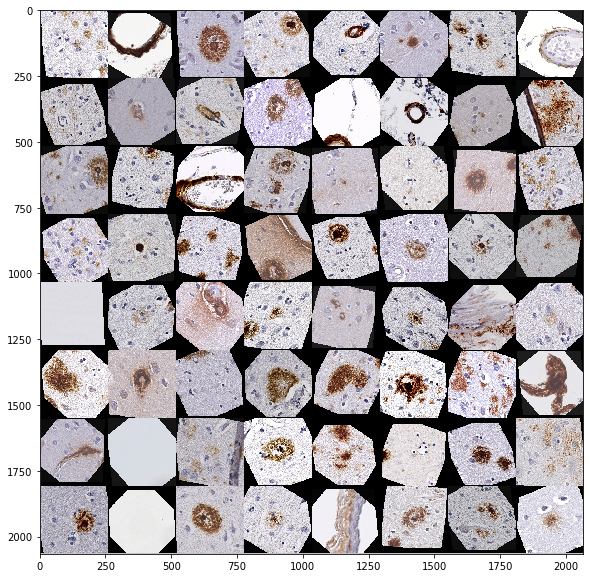

In [12]:
# Get a batch of training data
inputs, labels, raw_labels, names = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, norm)

In [15]:
weight = torch.FloatTensor([1,1,1])
model = Net()

if use_gpu:
    print('gpu')
    weight = weight.cuda()
    model = nn.DataParallel(model, device_ids=[0])
    model = model.cuda()
    
criterion = nn.MultiLabelSoftMarginLoss(weight=weight, size_average=False)
optimizer = optim.Adam(model.parameters(), lr=0.00008, weight_decay=0.008)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.4)

gpu


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [16]:
best_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=60)

Epoch 0/59
----------


/opt/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

In [ ]:
torch.save(best_model, SAVE_DIR+'CNN_model_parameters.pkl')

In [ ]:
plot_loss(model.module)